# Artificial Neural Network:  A story about quality analysis and hyperparameter optimization - 83.3% test score

## 1. Introduction

### 1.1 Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.


### 1.1 Content

* **1. Introduction**
* **2. Import libraries and data**
* **3. A first glance at the data**
* **4. Feature analysis**
* **5. Feature engineering**
* **6. Data preparation for modelling**
* **7. Modelling: Artificial Neural Network**
* **8. Conclusion**

* **Appendix A: Random Forest**
* **Appendix B: Gradient Boosting**

This notebook is intended to give an introduction for machine learning (ML) beginners on how to implement and optimize a simple artificial neural network (ANN) for data classification tasks.

To this end, I apply a state-of-the-art ML framework for building and training deep learning models - the Keras API for TensorFlow 2 - to one of the most famous data sets for ML beginners: the Kaggle competition "Titanic: Machine Learning from Disaster". The goal of this challenge is to create a ML model that predicts which passengers survived the Titanic tragedy. 

Despite the thousands of notebooks that have been uploaded for this Kaggle competition, most contributions just apply an ANN model that somehow works but neither show how to optimize nor how to evaluate an ANN model.

In the notebook, I explain how one can optimize the hyperparameters of an ANN using GridSearch and cross-validation. Moreover, I discuss in detail how to evaluate the quality of an ANN, analyzing e.g. the confusion matrix and the feature importance. 

In general, we will see that a simple ANN performs very well as a classifier on the titanic dataset (top 2% on the competition leaderboard and with 83.3% test score one of the best ANNs published for this competition) and outperfomrs strong ensemble methods like Random Forests and Gradient Boosting (80.8% test score, see Appendix).

Besides the detailed introduction to modeling with ANNs, the notebook includes standard techniques for feature analysis and engineering and shows how to prepare the data for modeling using pipelines.

I hope you enjoy the notebook and, of course, I am always happy to get some comments and feedback.

So let's get started...


This notebook has also been published on Kaggle:
https://www.kaggle.com/dantefilu/a-keras-neural-network-nn-83-3-test-score

## 2. Import libraries and data

In [1]:
#Import libraries

# data anlysis
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# data preparation for modelling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# model optimization
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
import eli5
from eli5.sklearn import PermutationImportance

# Random Forest and Gradient Boosting (Appendix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# ensure comparability of different runs
np.random.seed(42)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since 

In [2]:
#Import data

# load train and test data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# merge train and test data for common data processingg
data = pd.concat([train, test], axis=0, ignore_index=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## 3. A first glance at the data

In [3]:
# show first 20 entries of dataset
data[0:20]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [4]:
# get info about quality of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


We have 11 features (not counting *Survived*, which is our target) of different types (int64, float64, object), where for some features (*Age, Fare, Cabin*) data points are missing.

In [5]:
# check missing values
data.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

We will take care of the missing values later on in this notebook.

In [6]:
# statistics of nummeric features
data.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


We should check whether the high value of the maximum Fare is an outlier or just a very expensive Ticket.

## 4. Feature analysis

It is important to find out how the different features correlate with *Survived*. To this end, we use the training data for which the information about the passenger's survival is given (column *Survived*).

In [7]:
# Let's have a look at the correlation between Survived and all relevant numeric features in a correlation table ...
data.drop(columns=['PassengerId']).corr()

,Age,Fare,Parch,Pclass,SibSp,Survived
Age,1.000000,0.178740,-0.150917,-0.408106,-0.243699,-0.077221
Fare,0.178740,1.000000,0.221539,-0.558629,0.160238,0.257307
Parch,-0.150917,0.221539,1.000000,0.018322,0.373587,0.081629
Pclass,-0.408106,-0.558629,0.018322,1.000000,0.060832,-0.338481
SibSp,-0.243699,0.160238,0.373587,0.060832,1.000000,-0.035322
Survived,-0.077221,0.257307,0.081629,-0.338481,-0.035322,1.000000


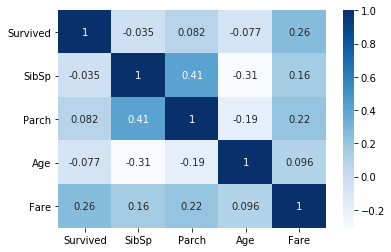

In [8]:
# ... or a color matrix
matrix = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), cmap = "Blues", annot=True)

The only numerical feature that strongly correlates with *Survived* is *Fare*. This might be explaind by the fact that the cabins of the richer passengers were mainly located in the upper parts of the boat, which was not directly fluted after the Titanic hit the iceberg. Moreover, the richer passengers were first to go on the life boats. 

This does not nessecarily mean that the other features are not relevant. 
For instance, although *Age* in general only shows a rather weak correlation with *Survived*, we should have a closer look at the children, which were allowed to go on the life boats first. Same for women, so the feature *Sex* might be important as well.

So let's have a closer look a the individual features in order to learn more about their importance.

### 4.1 *Pclass* (Passenger Class)

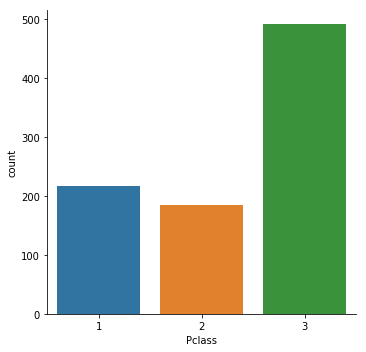

In [9]:
# Number of passengers per passenger class
plot = sns.catplot(x="Pclass", kind="count", data=train)

In the third class there are twice as much passengers than in the first and second class, respectively.

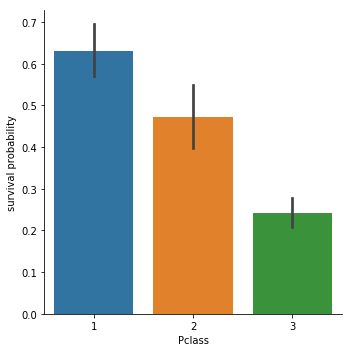

In [10]:
# plot Pclass vs survival probability
plot = sns.catplot(x="Pclass", y="Survived", kind="bar", data=train).set_ylabels("survival probability")

Indeed, the pobability to survive is higher the higher the class. This is an important feature. 

### 4.2 *Sex*

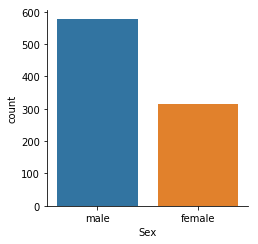

In [11]:
# Number of female and male passengers per passenger class
plot = sns.catplot(x="Sex", kind="count", data=train, height=3.5);

There are twice as much men on board than women.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


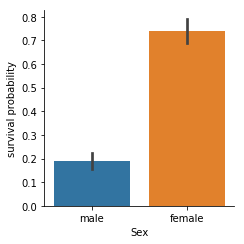

In [12]:
# plot Sex vs survival probability
plot = sns.catplot(x="Sex", y="Survived", kind="bar", data=train, size=3.5).set_ylabels("survival probability")

In general, the pobability of a woman to survive is more than three time higher than for a man. 

Let's have a look at this trend regarding the different passenger classes.

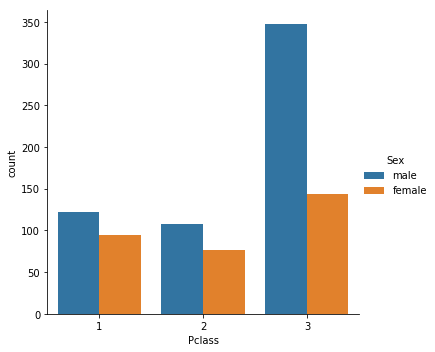

In [13]:
# Number of female and male passengers per passenger class
plot = sns.catplot(x="Pclass", hue="Sex", kind="count", data=train)

It is remarkable that the percentage of men in the third class is much bigger.

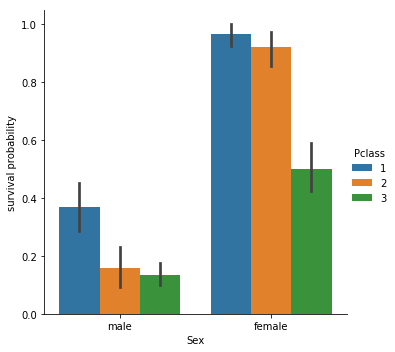

In [14]:
plot = sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train).set_ylabels("survival probability")

The survival probability for a man from the first class is twice as high than for a man from the second or third class. Regarding women, about 90 % of the women from the first and the second class survive, in contrast to only about 50% of the women in the third class.

### 4.3 *Age* 

We already mentioned that most likley certain age groups might have a higher probability to survive. Let's have a look at the statistics:

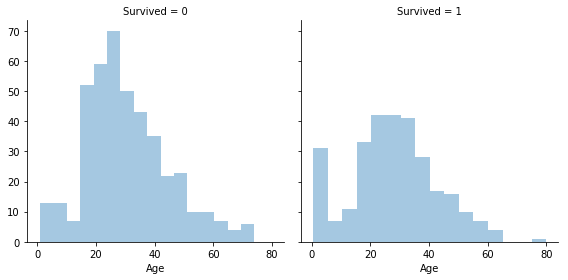

In [15]:
# Explore Age histogram for NotSurvived/Survived (0/1)
plot = sns.FacetGrid(train, col='Survived', height=4).map(sns.distplot, "Age", kde=False)


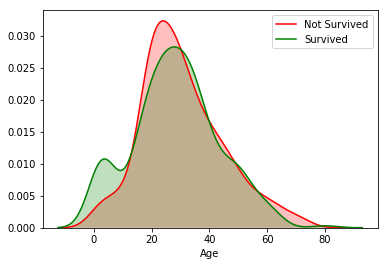

In [16]:
# Explore the respective Age distibutions 
Plot = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
plot = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], color="Green", shade= True)
plot.set_xlabel("Age")
plot = plot.legend(["Not Survived","Survived"])

Indeed, children have a much higher probability to survive. Let's illustrate the different survival probabilities by spliting *Age* in two categories, child (younger than 15) and adult.

#### New feature *AgeCat* (age categories)

We implement it here only for the training dataset to use it for further data analysis below. Later on in section 5 we will implement this feature for the whole dataset.

In [17]:
# We split the feature Age in two categories, child and adult
train["AgeCat"]= pd.cut(train["Age"], bins=[0,15,max(train["Age"]+1)], labels=['child','adult'])

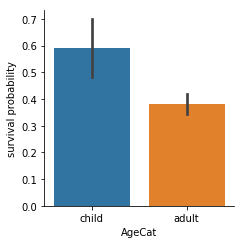

In [18]:
# plot survival probability of cildren and adults
plot = sns.catplot(x="AgeCat", y="Survived", kind="bar", data=train, size=3.5).set_ylabels("survival probability")

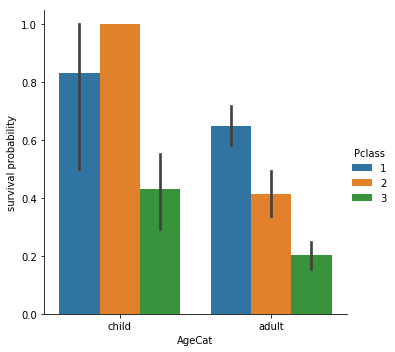

In [19]:
# plot survival probability of cildren and adults regarding the different classes
plot = sns.catplot(x="AgeCat", y="Survived", hue="Pclass", kind="bar", data=train).set_ylabels("survival probability")

From this diagram we learn that the chance to survive for a child from the third class is only about half the value compared to a child from the first or second class. Moreover, a child from the third class has a lower or rather similar probability to survive than an adult of the first or second class. 

### 4.4 *SibSp* (Siblings/Spouse)

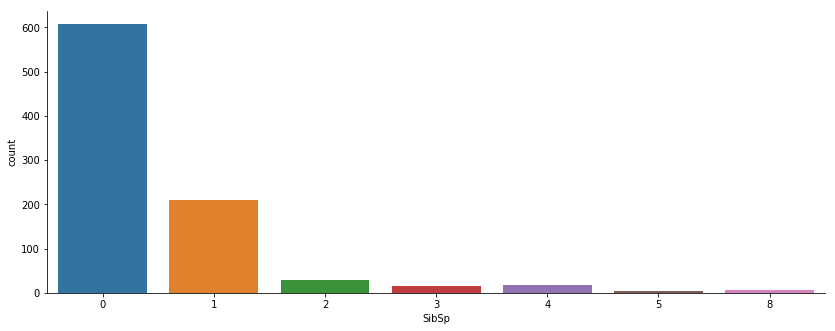

In [20]:
# Number of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp",kind="count", data=train, height=4.7, aspect=2.45)

Most passengers travel as singles.

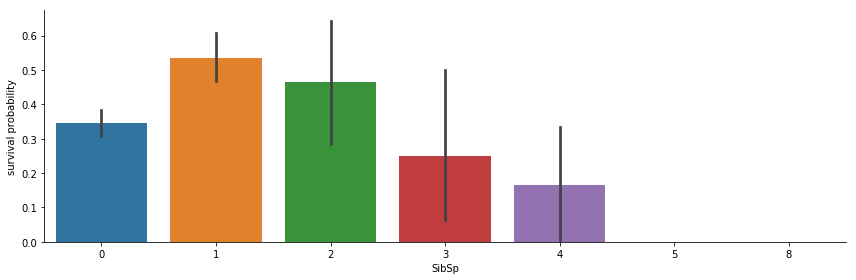

In [21]:
# Survival probability of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", y="Survived", kind="bar", data=train, height=4, aspect=3).set_ylabels("survival probability")

The survival chance of a passenger with 1 or 2 siblings/spouses is significantly higher than than for a single passenger or a passenger with 3 or more siblings/spouses. 

Since mainly adults (here older than 15 years) are married, let's analyse the data by splitting it between children and adults: 

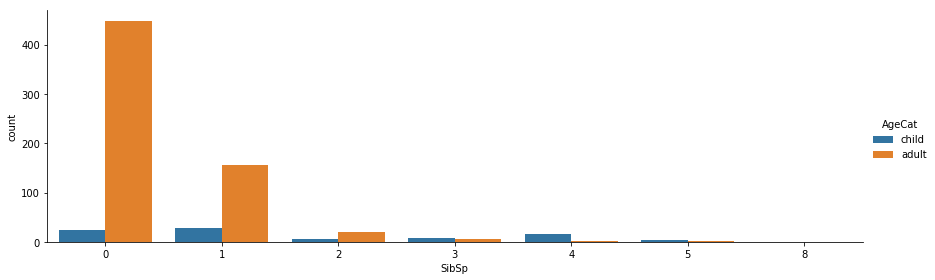

In [22]:
# Number of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", hue='AgeCat',kind="count", data=train, height=4, aspect=3)

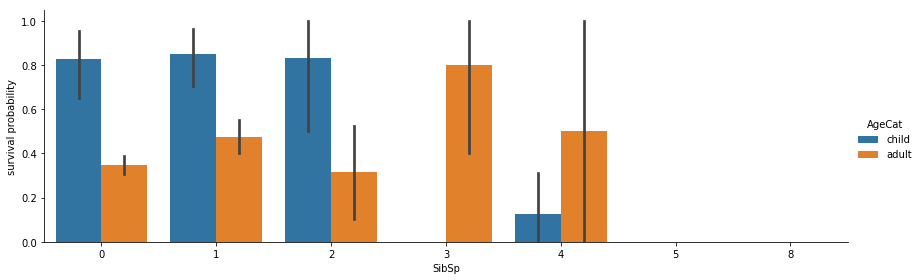

In [23]:
# Survival probability of passengers with no or several Siblings/Spouses
plot = sns.catplot(x="SibSp", y="Survived", hue="AgeCat", kind="bar", data=train, height=4, aspect=3).set_ylabels("survival probability")

The survival chance of a child with 2 or less siblings is much higher than than for a child with 3 or more siblings. On the contrary, for an adult with 2 or less (or more than 4) siblings the survival chance is lower than for an adult with 3 or 4 siblings. Hence, the family size seems to play an important role, too. To confirm this, we first have to analize *Parch*, aswell.

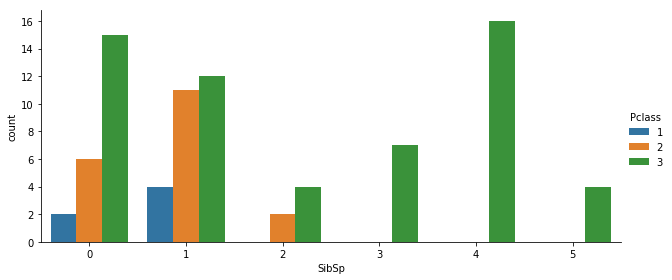

In [24]:
# Number of children with no or several siblings per class (assuming children younger than 15 are not married)
plot = sns.catplot(x="SibSp", hue='Pclass', kind="count", data=train[train['AgeCat']=='child'], height=4, aspect=2.15)

Obviously, the children in the third class have more siblings and hence the families are bigger (also see analysis of *Parch*)

### 4.5 Parch (Parents/children)

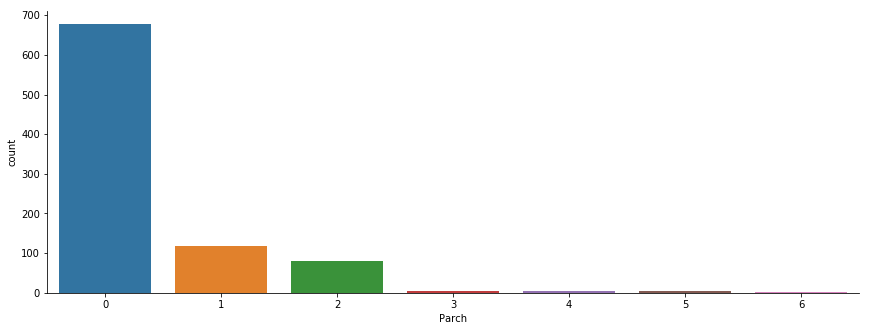

In [25]:
# Number of passengers with no or several parents/children
plot = sns.catplot(x="Parch",kind="count", data=train, height=4.7, aspect=2.55)

Most passengers have neither children nor parents on board.

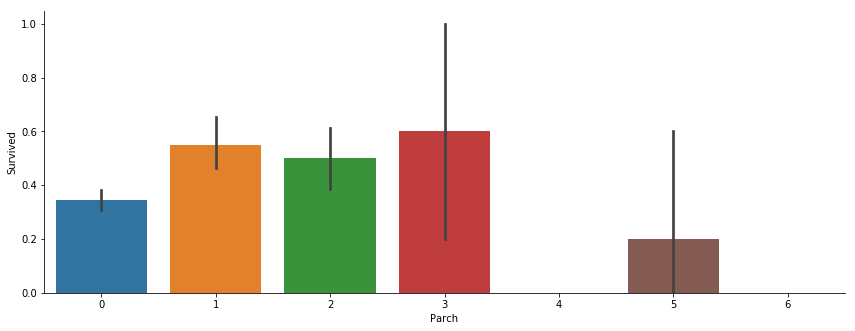

In [26]:
# Survival chance of passengers with no or several parents/children
plot = sns.catplot(x="Parch", y='Survived',kind="bar", data=train, height=4.7, aspect=2.55)

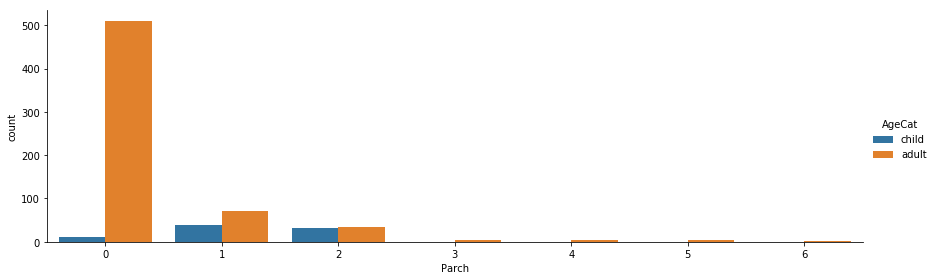

In [27]:
# Number of children/adults with no or several parents/children
plot = sns.catplot(x="Parch", hue='AgeCat',kind="count", data=train, height=4, aspect=3)

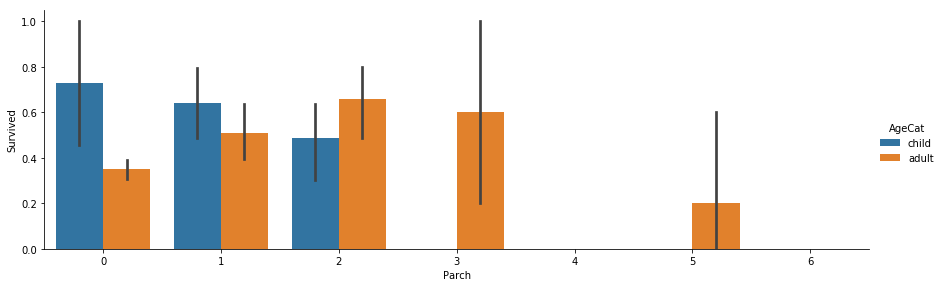

In [28]:
# Survival chance of children/adults with no or several parents/children
plot = sns.catplot(x="Parch", y='Survived', hue='AgeCat',kind="bar", data=train, height=4.1, aspect=3)

Note: We have set the age limit to still be a child to 15. So it might be that there are young adults (older than 15) which have parents on bord and children (15 or younger) that are already a parent (not as unusual as today at the beginning of the 20th century).

**Summary (also considering *SibSp*):**
The probability for a passenger to survive is the higher if he/she belongs to a smaller family instead of traveling alone (adult) or belonging to big family (more than 3 *SibSp* or *Parch*). We should consider this for feature engeneering. 

### 4.6 Fare

The correlation matrix we analyzed above showed that *Fare* has a strong correlation with the chance to survive. Let's explore the distribution of fares and how it correlates with survival.

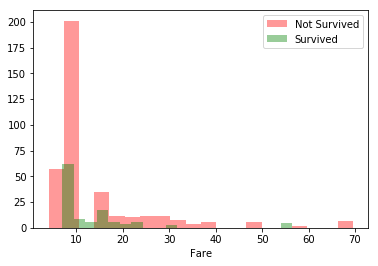

In [29]:
# Explore Fare distibution (you can change the different parameters below 
#to better understand the Fare distribution)
kde=False
upper=100  # upper limit for data in histogram
lower=0    # lower imit for data in histogram
Pclass=3   # type 0 for all classes

# perserve bin size for different parameters
bins=int((upper-lower)/5) 
if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plot = sns.distplot(train["Fare"][(train["Survived"] == 0) & (train["Fare"]< upper) & (train["Fare"]> lower) & (train["Pclass"]<upPclass) & (train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plot = sns.distplot(train["Fare"][(train["Survived"] == 1) & (train["Fare"]< upper) & (train["Fare"]> lower) & (train["Pclass"]<upPclass) & (train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plot.set_xlabel("Fare")
plot = plot.legend(["Not Survived","Survived"])

Analyzing the ditributions for different *Pclass* reveals that, for instance, some 3rd class tickets are much more expensive than the average 1st class ticket.

So let's have a look at these expensive 3rd class tickets with a price around 70:

In [30]:
train[['Fare','Name','Ticket','SibSp','Parch']].iloc[train.index[(train['Pclass']==3) & (train['Fare']>60)]]

,Fare,Name,Ticket,SibSp,Parch
159,69.55,"Sage, Master. Thomas Henry",CA. 2343,8,2
180,69.55,"Sage, Miss. Constance Gladys",CA. 2343,8,2
201,69.55,"Sage, Mr. Frederick",CA. 2343,8,2
324,69.55,"Sage, Mr. George John Jr",CA. 2343,8,2
792,69.55,"Sage, Miss. Stella Anna",CA. 2343,8,2
846,69.55,"Sage, Mr. Douglas Bullen",CA. 2343,8,2
863,69.55,"Sage, Miss. Dorothy Edith ""Dolly""",CA. 2343,8,2


Obviously, the price belongs to a ticket which was purchased for a whole family and not for a single passenger. Since the family relation is already coverd by other features licke *Parch*, *SibSp*, and *Ticket* it might be more informative to have ticket prices per passenger. So let's correct the ticket *Fare* and introduce a new feature *FareCorr* with the fare per passenger:

In [31]:
# the code below finds person groups which share the same tickets and 
# devides the ticket fare by the number of people in the group
train['FareCorr'] = train['Fare'].copy()

m=0 # m=0 -> print first iteration as example how the code works
for grp, grp_df in train[['Ticket', 'Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        if m==0:
            print(grp_df)
            m=1
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            train.loc[train['PassengerId'] == passID, 'FareCorr'] = train['Fare'][train['PassengerId'] == passID]/len(grp_df)


     Ticket                                               Name  Pclass  Fare  \
257  110152                               Cherry, Miss. Gladys       1  86.5   
504  110152                              Maioni, Miss. Roberta       1  86.5   
759  110152  Rothes, the Countess. of (Lucy Noel Martha Dye...       1  86.5   

     PassengerId  
257          258  
504          505  
759          760  


Now let's go back to the histograms and check how the distributions look like for *FareCorr*:

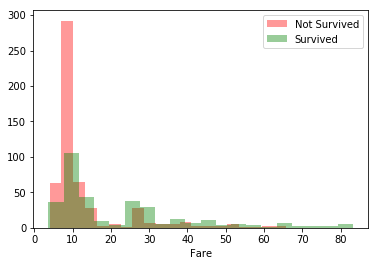

In [32]:
# Explore Fare distibution (you can change the different parameters below 
#to better understand the Fare distribution)
kde=False
upper=100  # upper limit for data in histogram
lower=0    # lower imit for data in histogram
Pclass=0   # type 0 for all classes

# perserve bin size for different parameters
bins=int((upper-lower)/5) 

if Pclass == 1 or Pclass == 2 or Pclass == 3:
    upPclass = Pclass+1
    lowPclass = Pclass
else: 
    upPclass = 4
    lowPclass = 1
    
plot = sns.distplot(train["FareCorr"][(train["Survived"] == 0) & (train["FareCorr"]< upper) & (train["FareCorr"]> lower) & (train["Pclass"]<upPclass) & (train["Pclass"]>=lowPclass)], bins=bins, color="Red", kde=kde)
plot = sns.distplot(train["FareCorr"][(train["Survived"] == 1) & (train["FareCorr"]< upper) & (train["FareCorr"]> lower) & (train["Pclass"]<upPclass) & (train["Pclass"]>=lowPclass)], bins=bins, color="Green", kde=kde)
plot.set_xlabel("Fare")
plot = plot.legend(["Not Survived","Survived"])

These distributions for the real fare per passenger now strongly correlate with *Pclass* and look more "natural". Hence, passengers ahich purchased a more expensive ticket have a higher probability to survive. This becomes obvious if we introduce fare categories *FareCat* based on *FareCorr* and analyze the survival rate:  

In [33]:
train['FareCat']=pd.cut(train['FareCorr'], bins=[0,15,65,max(train["FareCorr"]+1)], labels=['low','mid','high'])
train['FareCat'].value_counts()

low     618
mid     227
high     31
Name: FareCat, dtype: int64

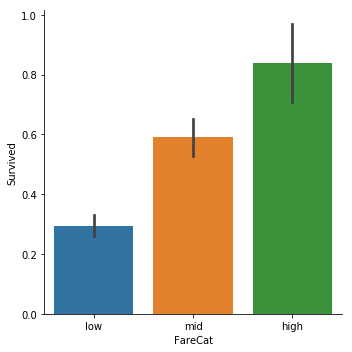

In [34]:
plot = sns.catplot(x="FareCat", y='Survived',kind="bar", data=train, height=5, aspect=1)


### 4.7 Embarked

The titanic had three different stops before it went on to cross the Atlantic - Southhampton (England), Cherbourg (France), and Queenstown (Ireland).

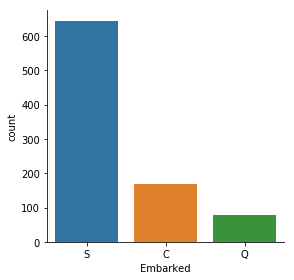

In [35]:
# Number of passengers that embarked a the three different habours
plot = sns.catplot(x="Embarked",kind="count", data=train, height=4, aspect=1)

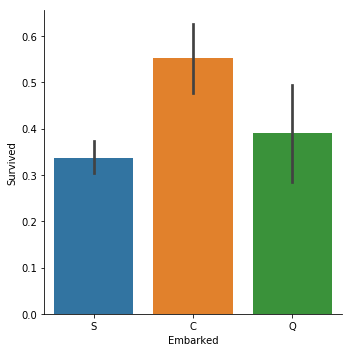

In [36]:
# Survival Probability of passengers emarked a the three different habours
plot = sns.catplot(x="Embarked", y='Survived', kind="bar", data=train, height=5, aspect=1)

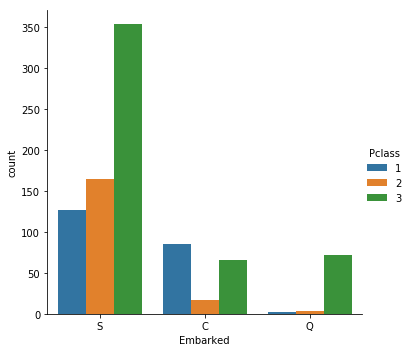

In [37]:
# Number of passengers emarked a the three different habours per class
plot = sns.catplot(x="Embarked", hue='Pclass',kind="count", data=train, height=5, aspect=1)

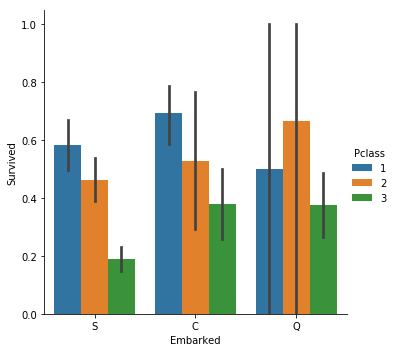

In [38]:
# Survival Probability of passengers emarked a the three different habours per class
plot = sns.catplot(x="Embarked", y='Survived', hue='Pclass', kind="bar", data=train, height=5, aspect=1)

Most passengers embarked in Southampton - one half 3rd class, the other half 1st and 2nd class passengers. The majority of the passengers which embarked in Cherbourg traveled in the 1st class, which explains the higher survival probability of this passenger group. It is remarkable that in Queenstwon mainly 3rd class passengers embarked, however, their survival probability is higher than for the passengers which embarked in Southamton. This might be relevant information.

### 4.8 Ticket and Cabin

In this notebook I will not further analyze these two features. As mentioned above discussing the feature *Fare*, the feature *Ticket* is very valuble to find groups that share the same ticket to correct the fare prices and implement the new *FareCorr*. Apart from that some tikets habe a letter which refers to the deck/level. Analyzing this together with the feature *Cabin*, where most of the entries are missing (or where the passengers had no cabin?!?), one could construct a new feature containing information about the survival probability regarding the deck/level. For more info have a look at the [wiki entry](https://en.wikipedia.org/wiki/RMS_Titanic).

## 5. Feature engineering and missing values

### 5.1 Add new feature *Title*

In [39]:
data['Name'][240:280]

240                            Zabour, Miss. Thamine
241                   Murphy, Miss. Katherine "Kate"
242                  Coleridge, Mr. Reginald Charles
243                    Maenpaa, Mr. Matti Alexanteri
244                             Attalah, Mr. Sleiman
245                      Minahan, Dr. William Edward
246            Lindahl, Miss. Agda Thorilda Viktoria
247                  Hamalainen, Mrs. William (Anna)
248                    Beckwith, Mr. Richard Leonard
249                    Carter, Rev. Ernest Courtenay
250                           Reed, Mr. James George
251       Strom, Mrs. Wilhelm (Elna Matilda Persson)
252                        Stead, Mr. William Thomas
253                         Lobb, Mr. William Arthur
254         Rosblom, Mrs. Viktor (Helena Wilhelmina)
255          Touma, Mrs. Darwis (Hanne Youssef Razi)
256                   Thorne, Mrs. Gertrude Maybelle
257                             Cherry, Miss. Gladys
258                                 Ward, Miss

The passengers have different titels which give information about their sex (Mr., Mrs., Miss., Master, Rev.), about their social status (Dr., Rev.) or about their age (Mrs., Miss., Master, Dr., Rev.). Characteristics which affect the survival probability. Hence, it makes sense to create a new feature *Title*.

In [40]:
# extracting the Title (which always ends with a ".")
for name_string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#transform titles which are synonyms
data['Title']=data['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

data['Title'].value_counts()

Mr          757
Miss        264
Mrs         198
Master       61
Rev           8
Dr            8
Col           4
Major         2
Capt          1
Sir           1
Lady          1
Jonkheer      1
Don           1
Countess      1
Dona          1
Name: Title, dtype: int64

The analysis reveals some more titles, some of which are noble titles or indicate a higher social standing. We now can summarize the different titles in the following categories: 

In [41]:
# Noble passengers
data['Title']=data['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')

# passengers with a higher social standing
data['Title']=data['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')

data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Others     23
Noble       6
Name: Title, dtype: int64

In the next section (5.2) we will introduce a further title called youngMiss, which is the female equivalent to master.




### 5.2 Add new feature *AgeCat* (age categories)

#### Fill missing values of *Age*

The best strategy to fill the missing values might be to use the titles to guess the age, since we are goint to divide *Age* in two categories, namely <15 and >15 years.   

In [42]:
data.groupby('Title')['Age'].median()

Title
Master     4.0
Miss      22.0
Mr        29.0
Mrs       35.0
Noble     39.5
Others    49.5
Name: Age, dtype: float64

With the title "Master" we are able to identify young male passengers, which have a significatly higher survival probability than adult men. For female passengers there is no dedicated title for young girls.

However, we can make use of the fact that young Misses (age<15) are most likely traveling at least with one parent, i.e. Parch >= 1. Let's check:

In [43]:
data['Parch'][(data['Age']<15) & (data['Title']=='Miss')].value_counts()

1    23
2    21
0     6
Name: Parch, dtype: int64

Only bout 12% of the Misses younger than 15 years have no parents/children on board. whereas between 15 and 20 ...

In [44]:
#Misses older than 15
data['Parch'][(data['Age']>=15) & (data['Age']<25) & (data['Title']=='Miss')].value_counts()

0    61
2    14
1    12
Name: Parch, dtype: int64

... already 63% of the Misses have no parents/children on board (). So a passenger with the title 'Miss' and a non-zero Parch value is most likly a young female.

So let's consider two categories, "Miss" and "young Miss": 

In [45]:
print('Average age of young Miss(age<15): '+ str(data['Age'][(data['Title']== 'Miss') & (data['Age']<15)].median()) + ' years')
print('Average age of Miss (age>=15): '+ str(data['Age'][(data['Title']== 'Miss') & (data['Age']>=15)].median()) + ' years')

Average age of young Miss(age<15): 5.0 years
Average age of Miss (age>=15): 24.0 years


Indeed, "youngMiss" shows about the same average age as "Master", which supports the assumption we made above.

Now we can fill the missing ages with the average values of the different titles and introduce "youngMiss" as a new title:

In [46]:
title_list=data.groupby('Title')['Age'].median().index.to_list()
# Filling missing age values 
for title in title_list:
    if title=='Miss':
        # Miss with Parch = 0 and missing age value: set median age >15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] == 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']>=15)].median()
        
        # Miss with Parch > 0 and missing age value: set median age <15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] > 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']<15)].median()
        
        # all Misses with Age < 15: set Title to youngMiss 
        data.loc[(data['Age']<15) & (data['Title'] == title), 'Title'] \
        = 'youngMiss'    
                                                 
    else: 
        data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] \
        = data['Age'][(data['Title']== title)].median()

In general, it should be noted that the survival probability for women in general is rather high, so we have to see later on whether introducing the title "young Miss" improves our prediction.

In [47]:
#check the average age for different titles
data.groupby('Title')['Age'].median()

Title
Master        4.0
Miss         24.0
Mr           29.0
Mrs          35.0
Noble        39.5
Others       49.5
youngMiss     5.0
Name: Age, dtype: float64

In [48]:
#check number of titles
data['Title'].value_counts()

Mr           757
Miss         204
Mrs          198
Master        61
youngMiss     60
Others        23
Noble          6
Name: Title, dtype: int64

#### Implement new feature *AgeCat*

In [49]:
# We split the feature Age in five categories, where category 1 refers to children (age<15)
data["AgeCat"]= pd.cut(data["Age"], bins=[0,14.9,30,45,60,max(data["Age"]+1)], labels=['1','2','3','4','5'])

# size of each category
data['AgeCat'].value_counts()

2    717
3    309
1    127
4    123
5     33
Name: AgeCat, dtype: int64

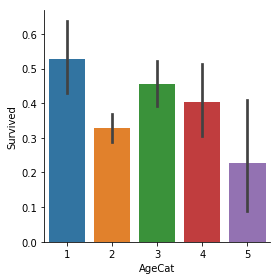

In [50]:
plot = sns.catplot(x='AgeCat', y='Survived', kind='bar', data=data[:len(train)], height=4)

Here I used 5 different Age categories.

### 5.3 Add new feature *FamilySize*

In the previous analysis we found that that family mebers of small families have a higher survival chance than singles or passengers with a big family. So let's implement this feature on the whole dataset:

In [51]:
# create feature FamilySize
data.loc[data['SibSp'] + data['Parch'] + 1 == 1, 'FamilySize'] = 'Single'
data.loc[data['SibSp'] + data['Parch'] + 1 > 1 , 'FamilySize'] = 'Small'
data.loc[data['SibSp'] + data['Parch'] + 1 > 4 , 'FamilySize'] = 'Big'

In [52]:
# size of each category
data.FamilySize.value_counts()

Single    790
Small     437
Big        82
Name: FamilySize, dtype: int64

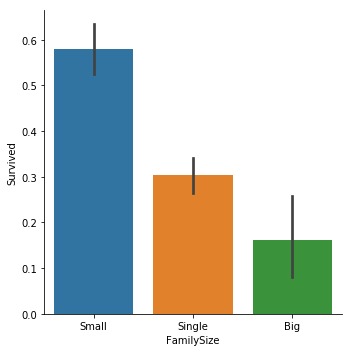

In [53]:
plot = sns.catplot(x='FamilySize', y='Survived', kind='bar', data=data[:len(train)])

### 5.4 Add new feature *FamilySurvival*

The inspiration for this feature came from [Konstantin](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83). The idea is to find groups of poeple, e.g. familes (share the same LastName/Ticket) or people that just travel together (share same Ticket). If the majority of this group survived, the feature FamilySurvival is set to 1. If the majority died, it is set to 0. For all other passengers which can not be associated with a group are, FamilySurvival is set to 0.5.

In [54]:
# extract last names
#data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
data['Last_Name'] =  data['Name'].str.extract('([A-Za-z]+),', expand=True)
data['Last_Name'].value_counts()
#data.groupby('Last_Name')

Sage           11
Andersson      11
Goodwin         8
Asplund         8
Davies          7
               ..
Danoff          1
Pain            1
Francatelli     1
Lindstrom       1
Eitemiller      1
Name: Last_Name, Length: 872, dtype: int64

In [55]:
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
default_value = 0.5

data['FamilySurvival'] = default_value
for grp, grp_df in data[['Survived', 'Last_Name', 'Ticket', 'PassengerId']].groupby(['Last_Name']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin == 0.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0
                
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        #print(grp_df)
        for ind, row in grp_df.iterrows():
            if (row['FamilySurvival'] == 0) | (row['FamilySurvival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
                elif (smin == 0.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0

# check number of passengers in the different categories
data['FamilySurvival'].value_counts()    

0.5    656
1.0    376
0.0    277
Name: FamilySurvival, dtype: int64

### 5.5 Add new features *FareCorr* and *FareCat*

We already introduced these feature in section 4.6. Now let's implement them for the whole dataset:

In [56]:
# Corret Fare per person
data['FareCorr'] = data['Fare'].copy()

for grp, grp_df in data[['Ticket','Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            data.loc[data['PassengerId'] == passID, 'FareCorr'] = data['Fare'][data['PassengerId'] == passID]/len(grp_df)

In [57]:
# Replacing one missing Fare value
fa = data[data["Pclass"] == 3]
data['FareCorr'].fillna(fa['FareCorr'].median(), inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
Age               1309 non-null float64
Cabin             295 non-null object
Embarked          1307 non-null object
Fare              1308 non-null float64
Name              1309 non-null object
Parch             1309 non-null int64
PassengerId       1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null object
SibSp             1309 non-null int64
Survived          891 non-null float64
Ticket            1309 non-null object
Title             1309 non-null object
AgeCat            1309 non-null category
FamilySize        1309 non-null object
Last_Name         1309 non-null object
FamilySurvival    1309 non-null float64
FareCorr          1309 non-null float64
dtypes: category(1), float64(5), int64(4), object(8)
memory usage: 175.5+ KB


Here, I use seven fare categories.

In [58]:
data['FareCat']=pd.qcut(data['FareCorr'], 7, labels=['1','2','3','4','5','6','7'])
data['FareCat'].value_counts()

2    236
5    212
1    188
7    186
4    167
6    162
3    158
Name: FareCat, dtype: int64

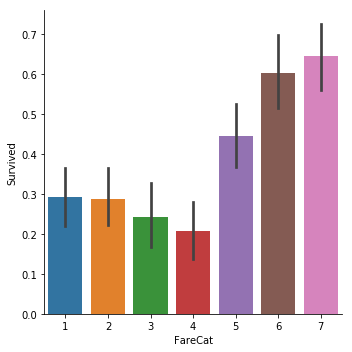

In [59]:
#Survival probability for each fare category
plot = sns.catplot(x="FareCat", y='Survived',kind="bar", data=data, height=5, aspect=1)


### 5.6 Add missing values for *Emarked*

In [60]:
data[data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,AgeCat,FamilySize,Last_Name,FamilySurvival,FareCorr,FareCat
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,3,Single,Icard,1.0,40.0,7
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,5,Single,Stone,1.0,40.0,7


In [61]:
data['Embarked'].fillna('C', inplace = True)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
Age               1309 non-null float64
Cabin             295 non-null object
Embarked          1309 non-null object
Fare              1308 non-null float64
Name              1309 non-null object
Parch             1309 non-null int64
PassengerId       1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null object
SibSp             1309 non-null int64
Survived          891 non-null float64
Ticket            1309 non-null object
Title             1309 non-null object
AgeCat            1309 non-null category
FamilySize        1309 non-null object
Last_Name         1309 non-null object
FamilySurvival    1309 non-null float64
FareCorr          1309 non-null float64
FareCat           1309 non-null category
dtypes: category(2), float64(5), int64(4), object(8)
memory usage: 177.1+ KB


Note: in the end I decided to not use this feature.

## 6. Data preparation for modelling

###  6.1 Drop useless features

In [63]:
data_pre = data.drop(['Embarked','Survived','PassengerId','Name','Age','Parch','SibSp','Ticket','Fare','Cabin','Last_Name','FareCorr'],axis=1)

In [64]:
#check data
data_pre

,Pclass,Sex,Title,AgeCat,FamilySize,FamilySurvival,FareCat
0,3,male,Mr,2,Small,0.0,2
1,1,female,Mrs,3,Small,0.5,7
2,3,female,Miss,2,Single,0.5,3
3,1,female,Mrs,3,Small,0.0,6
4,3,male,Mr,3,Single,1.0,4
...,...,...,...,...,...,...,...
1304,3,male,Mr,2,Single,0.5,4
1305,1,female,Noble,3,Single,1.0,7
1306,3,male,Mr,3,Single,0.5,2
1307,3,male,Mr,2,Single,0.5,4


In [65]:
# check data
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
Pclass            1309 non-null int64
Sex               1309 non-null object
Title             1309 non-null object
AgeCat            1309 non-null category
FamilySize        1309 non-null object
FamilySurvival    1309 non-null float64
FareCat           1309 non-null category
dtypes: category(2), float64(1), int64(1), object(3)
memory usage: 54.4+ KB


In [66]:
# create name lists for numerical an categorical features: we do not use any numerical features
num_attribs = []
cat_attribs = list( data_pre.drop(labels=num_attribs, axis=1).columns)

### 6.2 Prepare pipeline for numerical and categorical attributes

In [67]:
#Pipeline for numerical values
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [68]:
#Pipeline for categorical values
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat', OneHotEncoder()),
    ])

In [69]:
#Full pipeline

full_pipeline = ColumnTransformer([
        #("num", num_pipeline, num_attribs), # since we do not use any numerical features
        ('cat', cat_pipeline, cat_attribs),
    ])

data_post = full_pipeline.fit_transform(data_pre)

### 6.3 Alternative data preparation

If there are only cotegorical features with no missing values as it is the case for the current feature selection, the features can be transformed by simply using the OneHotEncoder:

In [70]:
oneHot=OneHotEncoder()
data_post_alt=oneHot.fit_transform(data_pre[cat_attribs])

This way we can easily extract the feature names after the encoding. This will help later on if we want to analyse the importance of the different features.

In [71]:
# extract feature names after encoding
feature_names = oneHot.get_feature_names(data_pre.columns)
feature_names

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Noble', 'Title_Others', 'Title_youngMiss', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5', 'FamilySize_Big',
       'FamilySize_Single', 'FamilySize_Small', 'FamilySurvival_0.0',
       'FamilySurvival_0.5', 'FamilySurvival_1.0', 'FareCat_1',
       'FareCat_2', 'FareCat_3', 'FareCat_4', 'FareCat_5', 'FareCat_6',
       'FareCat_7'], dtype=object)

###  6.4 Split prepared data into training and test datasets

In [72]:
# training data
X_train = data_post[:len(train['Survived']),:].toarray()
y_train = train['Survived'].copy().to_numpy()   # traget

# test data
X_test = data_post[len(train['Survived']):,:].toarray()

In [73]:
# check shape of X_train - number of instances and features
print('# instances: '+ str(X_train.shape[0]))
print('# features: '+ str(X_train.shape[1]))

# instances: 891
# features: 30


## 7.  Modelling: Artificial Neural Network 

Now we are going to explore how an artificial neural network (ANN) performs on the titanic dataset. 

For a first run and to get a feeling how the ANN works, in section 7.2 we will train a model with a given set of hyperparameters.  We are going to analyze the performance of the ANN and have a look at the importance of the different features.

In section 7.3, I show in deatil how the different hyperparameters of an ANN can be optimized using GridSearch and cross-validation.



In [74]:
# define functions
def hyperparameter_analysis(searcher, top_values=5):
    tested_hyperparameters=pd.DataFrame()
    for i in range(len(searcher.cv_results_['params'])):
        tested_hyperparameters = tested_hyperparameters.append(searcher.cv_results_['params'][i], ignore_index=True)
    tested_hyperparameters['train score in %']=(searcher.cv_results_['mean_train_score']*100).round(3)
    tested_hyperparameters['test score in %']=(searcher.cv_results_['mean_test_score']*100).round(3)
    tested_hyperparameters['test std in %']=(searcher.cv_results_['std_test_score']*100).round(3)
    tested_hyperparameters.index=searcher.cv_results_['rank_test_score']
    return(tested_hyperparameters.sort_index().head(top_values))

def feature_importance(searcher_best_estimator, list_feature_names, top_values=5):
    # calculate normed feature_importances
    fi_norm = 1/abs(searcher_best_estimator.feature_importances_).sum()*abs(searcher_best_estimator.feature_importances_)
    # create DataFrame 
    fi_df= pd.DataFrame(data=(fi_norm*100).round(2), index=list_feature_names, columns=['feature importance in %'])
    return(fi_df.sort_values(['feature importance in %'], ascending=[False]).head(top_values))

def feature_importance_ann(perm, list_feature_names, top_values=5, neg_values=False):    
    if neg_values==True:
        fi_df= pd.DataFrame(data=(perm.feature_importances_*100).round(2), index=list_feature_names, columns=['score reduction in % points'])
        return(fi_df[fi_df['score reduction in % points']<0]).sort_values(['score reduction in % points'], ascending=[True]).head(top_values)
    else:    
        fi_df= pd.DataFrame(data=(perm.feature_importances_*100).round(2), index=list_feature_names, columns=['score reduction in % points'])
        return(fi_df.sort_values(['score reduction in % points'], ascending=[False]).head(top_values))

def metric_scores(y_reference, y_prediction):
    precision = precision_score(y_reference, y_prediction)
    recall = recall_score(y_reference, y_prediction)
    F1_score = f1_score(y_reference, y_prediction)
    print('precision: '+ str(precision.round(3)))
    print('recall: '+ str(recall.round(3)))
    print('F1_score: '+ str(F1_score.round(3)))
    return(precision, recall, F1_score)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def pred_to_df(y_predicted):
    survived = pd.DataFrame(y_predicted,index=test.index, columns=['Survived'])
    survived['PassengerId'] = test.PassengerId 
    columns_titles = ["PassengerId","Survived"]
    survived=survived.reindex(columns=columns_titles)
    return(survived)

def save_to_csv(survived, filename,index=False):
    survived.to_csv(filename + '.csv',index=False, header=survived.columns)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    

### 7.1 The model

First of all, we define the function create_model() which gives us the freedom to try different model architectures by setting the respective hyperparameters. How I came up with default set of hyperparameters will be discussed in section 7.3.


In [75]:
def create_model(input_shape=X_train.shape[1:],
                number_hidden=2, 
                neurons_per_hidden=10,
                hidden_drop_rate= 0.2,
                hidden_activation = 'selu',
                hidden_initializer="lecun_normal",
                output_activation ='sigmoid',
                loss='binary_crossentropy',
                optimizer = Nadam(lr=0.0005),
                #lr=0.0005,
                ):
    
    #create model
    model = Sequential()
    model.add(Input(shape=input_shape)),
    for layer in range(number_hidden):
        model.add(Dense(neurons_per_hidden, activation = hidden_activation ,kernel_initializer=hidden_initializer))
        #model.add(Dropout(hidden_drop_rate))
    model.add(Dense(1, activation = output_activation))

    # Compile model
    model.compile(loss=loss, 
                  #optimizer = Nadam(lr=lr), 
                  optimizer = Nadam(lr=0.0005),
                  metrics = ['accuracy'])
    return model

### 7.2 A first look at neural networks on the titanic

So let's build a ANN classifier and train it:

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# build and compile ANN classifier by calling the model function
dnn_clf=create_model()

# train the ANN classifier
history = dnn_clf.fit(X_train, y_train, epochs=30, batch_size=30, verbose=0)

### 7.2.1 Evaluation of trained model

Now we can evaluate our trained classifier on the training dataset. 

In [77]:
# score of Ann classifier on training data
print('Training score: ' + str((pd.DataFrame(history.history)['accuracy'].max()*100)) + '%')

Training score: 85.07295250892639%


The training score of about 85% already looks very promissing for the titanic dataset. But what about the 15% false predictions? The question is whether we can still improve this or whether the training data (or the feature preparation) does not offer enough information to get better results.

So let's run the model on the training data and analyze the prediction in more detail.

In [78]:
# calculate predictions for training dataset X_train
y_train_pred_dnn = dnn_clf.predict_classes(X_train)

In general, the height of the score might not be the best measure to evaluate the performance of a classifier, especially if the dataset is skewed, i.e. one class is much smaller than the other (here about 38% survived, 62% died). It is more instructive to look at the confusion matrix and the metrics one can derive from it:

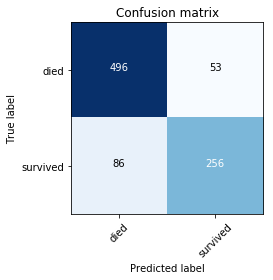

In [79]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_train_pred_dnn)

#plot confusion matrix
cm_plot=plot_confusion_matrix(cnf_matrix, ['died','survived'])

In [80]:
# show metrics
metric_scores(y_train, y_train_pred_dnn)

precision: 0.828
recall: 0.749
F1_score: 0.786


(0.8284789644012945, 0.7485380116959064, 0.7864823348694318)

The *recall* value tells us that our classifier detects 74.8% of all survivors (256/(256+86)).  Moreover, the *precision* value says that if the calssifier predicts a survivor (260), it is right in 82.8% (256/(256+53)) of all cases.

The the F1_score is the harmonic mean of precicion and recall and is a good measure for the overall quality of our classifier. A perfect calassifier would have a F1_score equal to one.

To further evaluate our model, we calculate the probabilities for all instance. If the probability is <0.5, the prediction for the instance/passenger is 0 (died). For probabilities <=0.5 the survival prediction is 1 (survived).

In [81]:
# calculate probabilities for training dataset X_train
y_train_proba_dnn = dnn_clf.predict(X_train)

The following histogram shows the distribution of the probabilities of all instances that were predicted **correctly** by the classifier.

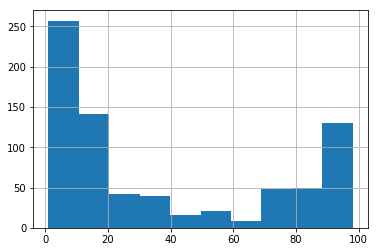

In [82]:
proba_df=pd.DataFrame(y_train_proba_dnn, columns=['probabilities'])*100
proba_df['false_predictions']=(pd.DataFrame(y_train_pred_dnn)-pd.DataFrame(y_train))[0]
proba_df['probabilities'][proba_df['false_predictions']==0].hist()

The high number to the left (around 0) and to the right (around 1) suggests that the classifier was quite certain in most of the predictions that turned out to be **right**.

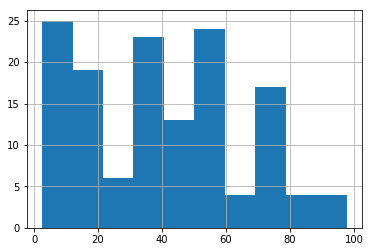

In [83]:
proba_df['probabilities'][proba_df['false_predictions']!=0].hist()

Regarding the **false** predictions, there is a majority around 0.5. Hence, cases where the information on the passenger was not conclusive enough to make a desicive prediction. By further feature engennering or by improving our model, it might be possible to predict some of this cases around 0.5 right.

However, there is also a high number of instances with probabilities close to 0, where the classifier obviously was convinced that the passenger died. 
A good example for such a case is the passenger with the ID 18 (see below) that was predicted to not survive. A young male passenger traveling in the second class whose other family mambers died - a clear case for our classifier - however, this man survived. Well, even the best classifier can not cover such cases if there is no additional information that would have indicated a survival of this passenger.

In [84]:
check_df=data[:891].copy()
check_df['false_predictions']=proba_df['false_predictions']
check_df['probabilities']=proba_df['probabilities']
#check_df[check_df['false_predictions']!=0].head()
check_df[check_df['PassengerId']==18]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,Title,AgeCat,FamilySize,Last_Name,FamilySurvival,FareCorr,FareCat,false_predictions,probabilities
17,29.0,NaN,S,13.0,"Williams, Mr. Charles Eugene",0,18,2,male,0,...,244373,Mr,2,Single,Williams,0.0,13.0,5,-1,4.786696


Looking for a way to improve the number of false predictions rises the question of how the model actually comes up with its decisions. 

For some classifiers (e.g. desicion trees) it is quite easy to trace how the decisions of the model. A neural network, however, is bit like a black box and it is usually not straight forward to understand or visualize the decision making. A nice visualization for a few simple problems can be found [here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.37306&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

So let's bring a bit of light into our model and have a look a the importance of the different features. To this end, we use [PermutationImportance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html) which is capable of computing feature importances for a number of black-box estimators by measuring how the score decreases when a feature is not available. in concrete, the feature importances is computed as mean decrease of the score when a feature is permuted, i.e. substitued by noise. 

To make use of PermutationImportance, we make use of the scikit-learn classifier API for Keras. To analyze the feature importances we have to create and train a KerasClassifier which is identical to our model. Here we go:

In [85]:
np.random.seed(42)
tf.random.set_seed(42)

# build and train KerasClassifier
dnn_clf_fi=KerasClassifier(build_fn = create_model)
dnn_clf_fi.fit(X_train, y_train, epochs=30, batch_size=30)

# calculate feature importance
perm = PermutationImportance(dnn_clf_fi, random_state=42).fit(X_train,y_train)


Train on 891 samples
Epoch 1/30
891/891 [==============================] - 1s 1ms/sample - loss: 0.7202 - accuracy: 0.4523
Epoch 2/30
891/891 [==============================] - 0s 70us/sample - loss: 0.6586 - accuracy: 0.6330
Epoch 3/30
891/891 [==============================] - 0s 69us/sample - loss: 0.6074 - accuracy: 0.7172
Epoch 4/30
891/891 [==============================] - 0s 70us/sample - loss: 0.5621 - accuracy: 0.7856
Epoch 5/30
891/891 [==============================] - 0s 68us/sample - loss: 0.5215 - accuracy: 0.7957
Epoch 6/30
891/891 [==============================] - 0s 67us/sample - loss: 0.4859 - accuracy: 0.8013
Epoch 7/30
891/891 [==============================] - 0s 66us/sample - loss: 0.4580 - accuracy: 0.8204
Epoch 8/30
891/891 [==============================] - 0s 68us/sample - loss: 0.4372 - accuracy: 0.8350
Epoch 9/30
891/891 [==============================] - 0s 67us/sample - loss: 0.4227 - accuracy: 0.8361
Epoch 10/30
891/891 [==============================] 

Below you can see the top 10 features:

In [86]:
feature_importance_ann(perm, feature_names, top_values=10, neg_values=False)

,score reduction in % points
Title_Mr,2.09
Title_Master,1.91
FamilySurvival_0.0,1.41
Sex_female,1.32
FamilySize_Big,1.14
Pclass_3,0.88
Sex_male,0.72
AgeCat_1,0.63
FamilySurvival_1.0,0.56
Title_Mrs,0.54


In [87]:
feature_importance_ann(perm, feature_names, top_values=20, neg_values=True)

,score reduction in % points
FareCat_7,-0.34
FareCat_6,-0.29
AgeCat_2,-0.20
FamilySurvival_0.5,-0.16
FareCat_4,-0.16
Title_Others,-0.13
FamilySize_Single,-0.13
Title_Miss,-0.11
FareCat_3,-0.11
FamilySize_Small,-0.09


Here, obviously the feature *Title_Mr* which was created during data preparation by the oneHotEncoder (chapter 6.2/6.3) is the most important feature. Moreover, it seems that all new features we created are somehow relevant for a good classification, which points out the important role of a solid feature engeneering.

If we turn the above table upside down, we se that there are som features which show a negative score:

A negative value means that our model might work better if we do not consider the respective feature.

Using SelectFromModel one can create a new training dataset containing only the most important features. The code below shows how to select the top 17 features. Optimizing the model on the best feature dataset might improve the general prediction score. I tested the top 17 features (hence, all features without negative values) and found that the validation score the score on the test data (kaggle) for incomparison to using the original 30 features.

I do not show this analysis here in detail but feel free to try and to further optimize the feature selection. To use the best feature datasets X_train_bf/X_test_bf as definded below, uncomment the respective line for the definition of the GridSearchCV datasets X_train_gs/X_test_gs as indicated below in section 7.3.

In [88]:
# select k best features
k = 17
sel = SelectFromModel(perm, threshold=-np.inf, max_features=k, prefit=True)
#get index of best features
best_festures_index=np.where(sel.get_support()==True)

# create training data with k selected features
X_train_bf = data_post[:len(train['Survived']),best_festures_index[0]].copy()
# create test data with k selected features
X_test_bf = data_post[len(train['Survived']):,best_festures_index[0]].copy()

In general, it should be mentioned that the feature importance strongly depends on the architecture of the model and the hyperparameters, i.e. a different number of layers or neurons per layer, for instance, may change the absolute and relative importance of single features. 
For instance, I testes the final model with and without implementing the title youngMiss. Although Title_youngMiss shows a feature importance of only 0.02 % points, including youngMiss improved the validation score and prediction on the test dataset by 0.5 % points. Also the absolut importances of the other features changed quite significnatly. 

Since some features are quite dominat and clear, one could try to build a wide & deep model where some features have more/less hidden layers to improve te quality of the model. Nervertheless, one should keep in mind that most of the times, the simple models are the best and more general ones.

### 7.2.2 Make predictions for the test dataset

Now, knowing that our model is already quite good, we are ready to make the final predictions.

In [89]:
# make predictions for X_test
y_pred_dnn = dnn_clf.predict_classes(X_test)

In [90]:
#convert to DataFrame and check
my_submission=pred_to_df(y_pred_dnn)
my_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [91]:
# save to csv file
save_to_csv(my_submission,'submission')

### 7.3 Find optimum hyperparameters using GridSearch and cross-validation

In the previous section, we have already seen how to build a pretty good ANN classifer. However, the hard part of getting a top classifier is to find the optimum set of hyperparameters. And this is what we are going to do now. 

For the optimization process I went through the following steps using GridSearchCV:

1. Setting the activation function and the respective kernel initializer
As the activation function for the hidden layers I chose the scaled exponential linear unit function *SELU* with the respective LeCun initialization. Using the [*SELU*](https://arxiv.org/abs/1706.02515) the network will self-normalize, where the output of each layer will preserve a mean of 0 and std of 1 during the training. This is in particular benefitial for deep networks which may face problems with vanishing/exploding gradients. For our rather shallow model this should not be a problem, nevertheless, the *SELU* performed at least 0.5% better than *ElU* or *ReLU* for different hyperparameters. 

2. Finding the best Optimizer
I tried a number of different optimizers (see parameter grid below) and adtaptive moment estimation with the method, aka [*Nadam*](http://cs229.stanford.edu/proj2015/054_report.pdf), turned out to be the best one.

2. Evaluationg the optimum learning
The learing rate is the most likely the most important parameter. There are several techniqus to optimize the learing rate like ploting the learning curve for various learning rates or using elaborate methods like [*1cycle sheduling*](https://arxiv.org/abs/1803.09820). I tried several techniques, but for our rather simple model it was most practical to try different learning rates using GridSearchCV. I found a learning rate of 0.0005 (half the default value for Nadam) to deliver the best results.

3. Optimizing the number of epochs
Having found a good learning rate, one has to optimize the number of epochs per training run. I found 30 epochs to be a good number not to overfit the model. In general, to prevent overfitting one can use techniques like EarlyStopping or plot/compare the training vs the validation loss/score for a series of epochs (discussed below).
I implemented EarlyStopping with a callback for GridSearchCV (see below), however, it was more practical to simply optimze the epochs and check that the training and the validation score do not diverge with increasing epochs. Especially, since with *patience* one introduces another hyperparameter which has to be optimized. Moreover, it should be noted that before using EarlyStopping whith cross-validation, [a few things](https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation) should to be considered.

4. Finding the optimum batch size 
Again I used GridSearchCV and found 20 instances to be the best batch size. In general, what is the maximum batch size one should use is still under discussion. There are several controverse discussions in the community.

5. Find the best model architecture:
GridSearchCV found three combinations to be very similar in performance: #layers/#neurons: 3/10, 3/15, 2/10. 
The score of the three models lay within 0.3%. In the end I chose 2 hidden layers with 10 neurons each, since it performed best on the test data.

One can optimze the hyperparameters by running GridSearch for all different parameters at once, which might take quite a while or find the best parameters by optimizing only one or a few parameters at a time and see how the model performs. Using the latter step-by-step method, it should be noted that one might have to go several times through the different steps in order to find the optimum parameters. 

So here is the GridSearchCV approach using a KerasClassifier:

In [92]:
#If you want to optimize with the "best features" dataset X_train_bf, uncomment below.

# training data: default is X_train as used before 
X_train_gs=X_train.copy()
#X_train_gs=X_train_bf.copy() #best feature dataset

# test data: default is X_train as used before
X_test_gs=X_test.copy()
#X_test_gs=X_test_bf.copy()  #best feature dataset

In [93]:
# check shape of X_train - number of instances and features
print('# instances: '+ str(X_train_gs.shape[0]))
print('# features: '+ str(X_train_gs.shape[1]))

# instances: 891
# features: 30


In [94]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# build classifier
dnn_clf_gs = KerasClassifier(build_fn = create_model, verbose = 0)

# define parameter grid: 
# uncomment the parameters you want to optimize
param_grid = {
    #"optimizer": ['Adam', 'Nadam', 'Adagrad', 'Adamax'],
    #"lr":[0.005,0.001,0.0005]
    #"epochs": [15, 30, 45, 60],
    #"batch_size": [20,30,40],
    #"number_hidden": [1, 2, 3],
    #"neurons_per_hidden": [5, 10, 15],
    'input_shape': X_train_gs.shape[1:]  # keep this line
}

# build GridSearchCV model with ANN classifier
grid_search_dnn = GridSearchCV(dnn_clf_gs, param_grid, cv=5, n_jobs=-1, verbose=0, return_train_score=True)

# fit GridSearchCV model
history_gs = grid_search_dnn.fit(X_train_gs, y_train,
                                 epochs = 30, 
                                 batch_size = 30,
                                 #validation_data=(X_valid_dnn, y_valid_dnn),
                                 #callbacks=[keras.callbacks.EarlyStopping(patience=8)]
                                )
                                    

In [95]:
# mean scores for training and validation model after cross-validation
print('Mean training score:   ' + str((grid_search_dnn.cv_results_['mean_train_score'][grid_search_dnn.best_index_]*100).round(2)) +'% (' + str((grid_search_dnn.cv_results_['std_train_score'][grid_search_dnn.best_index_]*100).round(2)) + '%)')
print('Mean validation score: ' + str((grid_search_dnn.cv_results_['mean_test_score'][grid_search_dnn.best_index_]*100).round(2)) +'% (' + str((grid_search_dnn.cv_results_['std_test_score'][grid_search_dnn.best_index_]*100).round(2)) + '%)')

Mean training score:   84.88% (0.77%)
Mean validation score: 82.83% (1.87%)


The validation score evulated by cross-validation is quite close to the 83.3% score obtained for the test dataset. 
Also the training and validation score are rather similar which suggests that there is no/little overfitting. Hence, the model seems to be optimzed quite well.

To see when overfitting sets in one can plot the training versus validation score/loss for several epochs (aka learning curve). 

In [96]:
# set of optimized hyperparameters -> best model
pd.DataFrame(grid_search_dnn.best_params_.items(), columns=['hyperparameter','value'])

,hyperparameter,value
0,input_shape,30


In [97]:
# top 10 hyperparameter sets
hyperparameter_analysis(grid_search_dnn, 10)

,input_shape,train score in %,test score in %,test std in %
1,30.0,84.876,82.828,1.87


In [98]:
y_pred_dnn_opti = grid_search_dnn.best_estimator_.predict(X_test_gs)

In [99]:
survived_dnn_opti=pred_to_df(y_pred_dnn_opti)
survived_dnn_opti.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [100]:
save_to_csv(survived_dnn_opti,'survived_dnn_opti')

### 8. Conclusions

With this ANN classifier you should obtain 83.3% on the test dataset (kaggle). With the current set of features, the ANN classifier performs much better than strong ensemble methods like *Random Forests* and *Gradient Boosting* which only achieved about 80.8% on the test data. An analysis of both classifiers can be found in appedix A and B of this notebook.

I tried a lot of different approaches for feature analysis, feature engineering, data preparation and for the final model (hence, the large number of submissions). I tried to summarized the most important aspects in this notebook.

We learned that feature engineering and the implementation of new features based on a carefull analysis of the existing features is indispensable for building a powerfull classifier. Especially since ANNs seem to be quite sensitive for variations in the feature set.

Moreover, we saw that GridSearchCV can be very usefull tool to optimize the hyperparameters. It should be noted that for a rather small dataset, as it is the case for the *Titanic Desaster*, it is not advisable to create a further validation data set from the training data (tried it, model does not generalize well anymore), so using cross-validation is essential.

In general, with a good optimization, ANNs seem to perform very well on the titanic datasets. 

I hope you enjoyed this notebook and, of course, comments and feedback are highly appreciated.



# Appendix 

## A: Random Forests

### RF: Modelling

In [101]:
# Find optimum hyperparameters with RandomSearch

param_distribs = {
        'n_estimators': randint(low=50, high=150),
        'max_features': randint(low=5, high=15),
        'min_samples_split': randint(low=10, high=30),
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search_rf = RandomizedSearchCV(forest_clf, param_distributions=param_distribs, n_jobs=-1,
                                n_iter=50, cv=5, scoring="accuracy", random_state=42, return_train_score=True)
rnd_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [102]:
# score of best model after cross-validation
print('Best score: ' + str((rnd_search_rf.best_score_*100).round(2)) + '%')

Best score: 84.85%


In [103]:
# mean scores for training and validation model after cross-validation
print('Mean training score:   ' + str((rnd_search_rf.cv_results_['mean_train_score'][rnd_search_rf.best_index_]*100).round(2)) +'% (' + str((rnd_search_rf.cv_results_['std_train_score'][0]*100).round(2)) + '%)')
print('Mean validation score: ' + str((rnd_search_rf.cv_results_['mean_test_score'][rnd_search_rf.best_index_]*100).round(2)) +'% (' + str((rnd_search_rf.cv_results_['std_test_score'][0]*100).round(2)) + '%)')

Mean training score:   87.4% (0.49%)
Mean validation score: 84.85% (2.09%)


In [104]:
# set of optimized hyperparameters -> best model
pd.DataFrame(rnd_search_rf.best_params_.items(), columns=['hyperparameter','value'])

,hyperparameter,value
0,max_features,5
1,min_samples_split,14
2,n_estimators,90


In [105]:
# top 5 hyperparameter sets
hyperparameter_analysis(rnd_search_rf)

,max_features,min_samples_split,n_estimators,train score in %,test score in %,test std in %
1,5.0,14.0,90.0,87.402,84.848,1.979
2,5.0,19.0,141.0,86.588,84.622,2.585
3,8.0,12.0,100.0,87.739,84.512,1.931
4,6.0,13.0,138.0,87.598,84.511,1.766
5,8.0,14.0,72.0,87.710,84.287,1.847


In [106]:
feature_importance(rnd_search_rf.best_estimator_, feature_names, 10)

,feature importance in %
Title_Mr,16.07
Sex_female,12.93
Sex_male,12.13
Pclass_3,5.50
FamilySurvival_0.0,5.04
Title_Miss,4.85
Title_Mrs,4.48
FamilySurvival_1.0,4.41
FamilySize_Small,3.58
FamilySize_Big,3.15


In [107]:
# set best estimator as final model
final_rf_clf = rnd_search_rf.best_estimator_
final_rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=14,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### RF: Predict training data for further evaluation

In [108]:
y_train_pred_rf = final_rf_clf.predict(X_train)

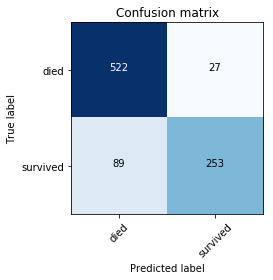

In [109]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_train_pred_rf)

#plot confusion matrix
cf=plot_confusion_matrix(cnf_matrix, ['died','survived'])

In [110]:
# show metrics
metric_scores(y_train, y_train_pred_rf)

precision: 0.904
recall: 0.74
F1_score: 0.814


(0.9035714285714286, 0.7397660818713451, 0.8135048231511254)

### RF: Prediction for test dataset


In [111]:
y_pred_rf = final_rf_clf.predict(X_test)

In [112]:
survived_rf=pred_to_df(y_pred_rf)
survived_rf.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [113]:
save_to_csv(survived_rf,'survived_rf')

## B: Gradient Boosting Classifier

### GB: Modelling

In [114]:
param_distribs = {
        #'learning_rate': randint(low=0.1, high=0.1),
        'max_depth': randint(low=1, high=5),
        'n_estimators': randint(low=5, high=120),
        'max_features': randint(low=5, high=15),
    }

gb_clf = GradientBoostingClassifier()
rnd_search_gb = RandomizedSearchCV(gb_clf, param_distributions=param_distribs,
                                n_iter=40, cv=5, scoring="accuracy", random_state=42, return_train_score=True)
rnd_search_gb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [115]:
# mean scores for training and validation model after cross-validation
print('Mean training score:   ' + str((rnd_search_gb.cv_results_['mean_train_score'][rnd_search_gb.best_index_]*100).round(2)) +'% (' + str((rnd_search_gb.cv_results_['std_train_score'][0]*100).round(2)) + '%)')
print('Mean validation score: ' + str((rnd_search_gb.cv_results_['mean_test_score'][rnd_search_gb.best_index_]*100).round(2)) +'% (' + str((rnd_search_gb.cv_results_['std_test_score'][0]*100).round(2)) + '%)')

Mean training score:   87.51% (0.76%)
Mean validation score: 84.62% (1.76%)


In [116]:
rnd_search_gb.cv_results_['mean_train_score']

array([0.87514183, 0.86812487, 0.84259144, 0.87654435, 0.85465827,
       0.80807909, 0.85100777, 0.87121279, 0.86952976, 0.82743827,
       0.8785071 , 0.89113337, 0.86672274, 0.84343217, 0.85381439,
       0.80667854, 0.88496108, 0.82547394, 0.81537222, 0.87738705,
       0.82771877, 0.85605922, 0.82463597, 0.85100856, 0.85269237,
       0.84090723, 0.88327686, 0.84286958, 0.87261571, 0.86868628,
       0.89057157, 0.84483627, 0.81902075, 0.81397167, 0.8723352 ,
       0.87682486, 0.84231093, 0.87121397, 0.87065257, 0.84315245])

In [117]:
# set of optimized hyperparameters -> best model
pd.DataFrame(rnd_search_gb.best_params_.items(), columns=['hyperparameter','value'])

,hyperparameter,value
0,max_depth,3
1,max_features,8
2,n_estimators,97


In [118]:
# top 5 hyperparameter sets
hyperparameter_analysis(rnd_search_gb, 5)

,max_depth,max_features,n_estimators,train score in %,test score in %,test std in %
1,3.0,8.0,97.0,87.514,84.624,1.759
2,4.0,6.0,78.0,88.328,84.399,1.864
3,3.0,12.0,104.0,87.654,84.287,1.847
4,4.0,11.0,48.0,87.739,84.286,2.111
5,3.0,5.0,93.0,87.234,84.174,2.120


In [119]:
# top 10 important features
feature_importance(rnd_search_gb.best_estimator_, feature_names, 10)

,feature importance in %
Title_Mr,20.29
Sex_male,20.21
Pclass_3,8.06
Title_Miss,7.05
FamilySurvival_1.0,5.45
FamilySize_Big,5.22
Pclass_1,4.99
FamilySize_Small,4.68
FamilySurvival_0.0,4.17
Sex_female,3.21


In [120]:
# set best estimator as final model
final_gb_clf = rnd_search_gb.best_estimator_
final_gb_clf

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=97,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### GB: Predict training data for further evaluation

In [121]:
y_train_pred_gb = final_gb_clf.predict(X_train)

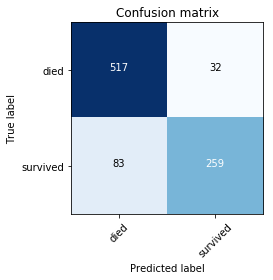

In [122]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_train_pred_gb)

#plot confusion matrix
plot_confusion_matrix(cnf_matrix, ['died','survived'])

In [123]:
# show metrics
metric_scores(y_train, y_train_pred_gb)

precision: 0.89
recall: 0.757
F1_score: 0.818


(0.8900343642611683, 0.7573099415204678, 0.8183254344391786)

### GB: Prediction for test dataset


In [124]:
y_pred_gb = final_gb_clf.predict(X_test)

In [125]:
survived_gb=pred_to_df(y_pred_gb)
survived_gb.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [126]:
save_to_csv(survived_gb,'survived_gb')

## End of Appendix